In [1]:
#加载库文件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary

In [2]:
#检测是否存在cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

In [3]:
hyperparameter_defaults = dict(
    epochs = 50,
    batch_size = 8,
    img_size = 224,
    num_workers = 4,
    model_name = "class_pytorch"
)

# import wandb
# from datetime import datetime
# wandb.login(key="a96035366c44c4ac930354c4d3bda0f9499c339e")
# current_time = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
# run_name = "run_" + current_time

# config = {
#     "project":"Pistachio_Class_pytorch",
#     "name": run_name,
#     "config":hyperparameter_defaults
# }

In [4]:
train_transform=transforms.Compose([
        transforms.Resize(hyperparameter_defaults["img_size"]),             # resize shortest side to 224 pixels
        #transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        #transforms.CenterCrop(112),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
test_transform=transforms.Compose([
        transforms.Resize(hyperparameter_defaults["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
#分类图像的路径
data_path = r"D:\code_study\ML_CODE\dataSets\Classification\Pistachio_Image_Dataset\Pistachio_Image_Dataset"
data_path = data_path.replace("\\", "/")
full_dataSet = datasets.ImageFolder(root=data_path, transform=None)
print(len(full_dataSet))
# 输出类别数
num_classes = len(full_dataSet.classes)
print(f"Number of categories: {num_classes}")
#手动划分train/test数据集
train_size = int(0.8 * len(full_dataSet))
valid_size = int(0.1 * len(full_dataSet))
test_size = len(full_dataSet) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataSet, [train_size, valid_size, test_size])

# 为每个子集设置不同的 transform（通过 monkey patch 方法）
train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# 使用 DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hyperparameter_defaults["batch_size"], 
                                           shuffle=True, num_workers=hyperparameter_defaults["num_workers"])
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=hyperparameter_defaults["batch_size"], 
                                           shuffle=False, num_workers=hyperparameter_defaults["num_workers"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hyperparameter_defaults["batch_size"], 
                                          shuffle=False, num_workers=hyperparameter_defaults["num_workers"])
len(train_loader), len(valid_loader), len(test_loader)

14492
Number of categories: 3


(1450, 182, 182)

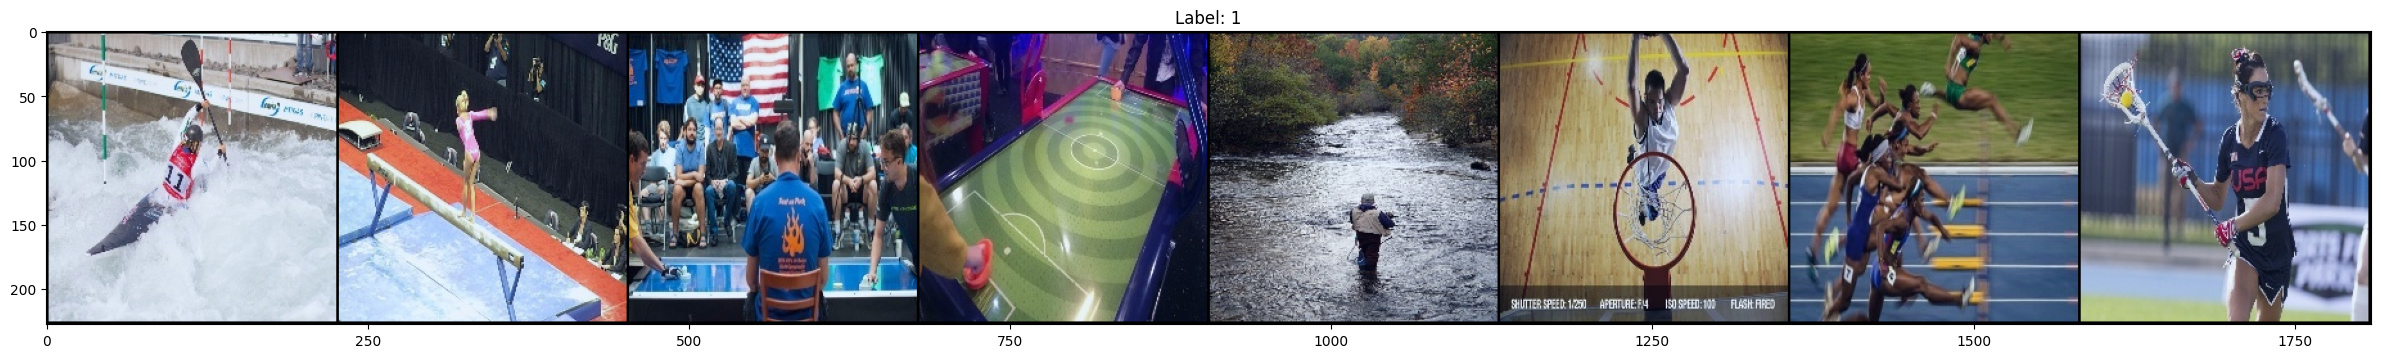

In [6]:
# visualize train data
def visualize(dataloader):
    images , labels = next(iter(dataloader))
    grid = make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(30, 30))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Label: {labels[0]}")
    plt.show()
visualize(train_loader)

In [7]:
#定义模型
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = nn.Sequential(
            # 第一层
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 第二层
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 第三层
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 第四层
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 第五层
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #展平
            nn.Flatten(),
            #全连接层
            nn.Linear(in_features=256*5*5, out_features=4096),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(in_features=2048, out_features=num_classes)

        )

    def forward(self, x):
        return self.model(x)

In [8]:
# create model instance
model = AlexNet().to(device)

In [9]:
summary(model, input_size=(hyperparameter_defaults["batch_size"], 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [8, 3]                    --
├─Sequential: 1-1                        [8, 3]                    --
│    └─Conv2d: 2-1                       [8, 96, 54, 54]           34,944
│    └─ReLU: 2-2                         [8, 96, 54, 54]           --
│    └─MaxPool2d: 2-3                    [8, 96, 26, 26]           --
│    └─Conv2d: 2-4                       [8, 256, 26, 26]          614,656
│    └─ReLU: 2-5                         [8, 256, 26, 26]          --
│    └─MaxPool2d: 2-6                    [8, 256, 12, 12]          --
│    └─Conv2d: 2-7                       [8, 384, 12, 12]          885,120
│    └─ReLU: 2-8                         [8, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [8, 384, 12, 12]          1,327,488
│    └─ReLU: 2-10                        [8, 384, 12, 12]          --
│    └─Conv2d: 2-11                      [8, 256, 12, 12]       

In [ ]:
#设置优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

: 

In [ ]:
epochs = hyperparameter_defaults["epochs"]
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    for images, labels in train_loader:
        #move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        #clear gradients
        optimizer.zero_grad()

        #forward pass
        outputs = model(images)
        train_loss = loss_fn(outputs, labels)

        #backward pass
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item() * images.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    #Validation phase
    model.eval()
    epoch_valid_loss = 0.0
    with torch.inference_mode():
        for val_images, val_labels in valid_loader:
            #move data to GPU
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            #forward pass
            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            epoch_valid_loss += val_loss.item() * val_images.size(0)

    epoch_valid_loss /= len(valid_loader.dataset)
    valid_losses.append(epoch_valid_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")


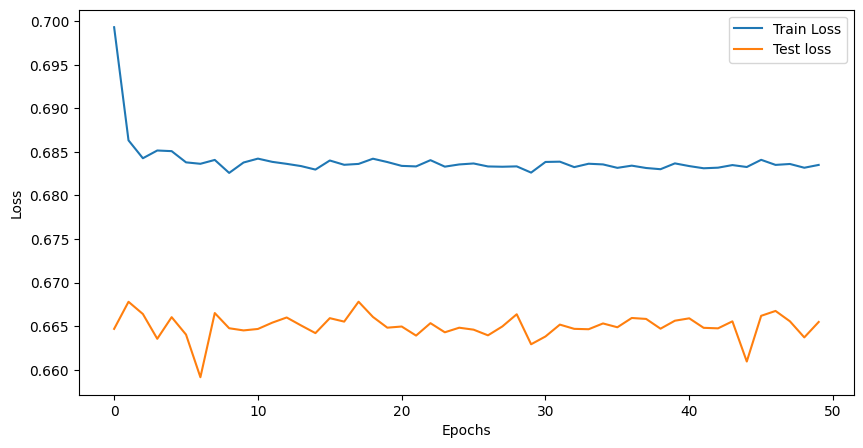

In [ ]:
#画出训练曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
#Test model
predicted_labels = []
actual_labels = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predicted_labels.extend(preds.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

Model Accuracy:53.24%
Model Precision: 28.35%
Model Recall:53.24%
Model F1 Score:37.00%
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       115
           1       0.00      0.00      0.00       101

    accuracy                           0.53       216
   macro avg       0.27      0.50      0.35       216
weighted avg       0.28      0.53      0.37       216



c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

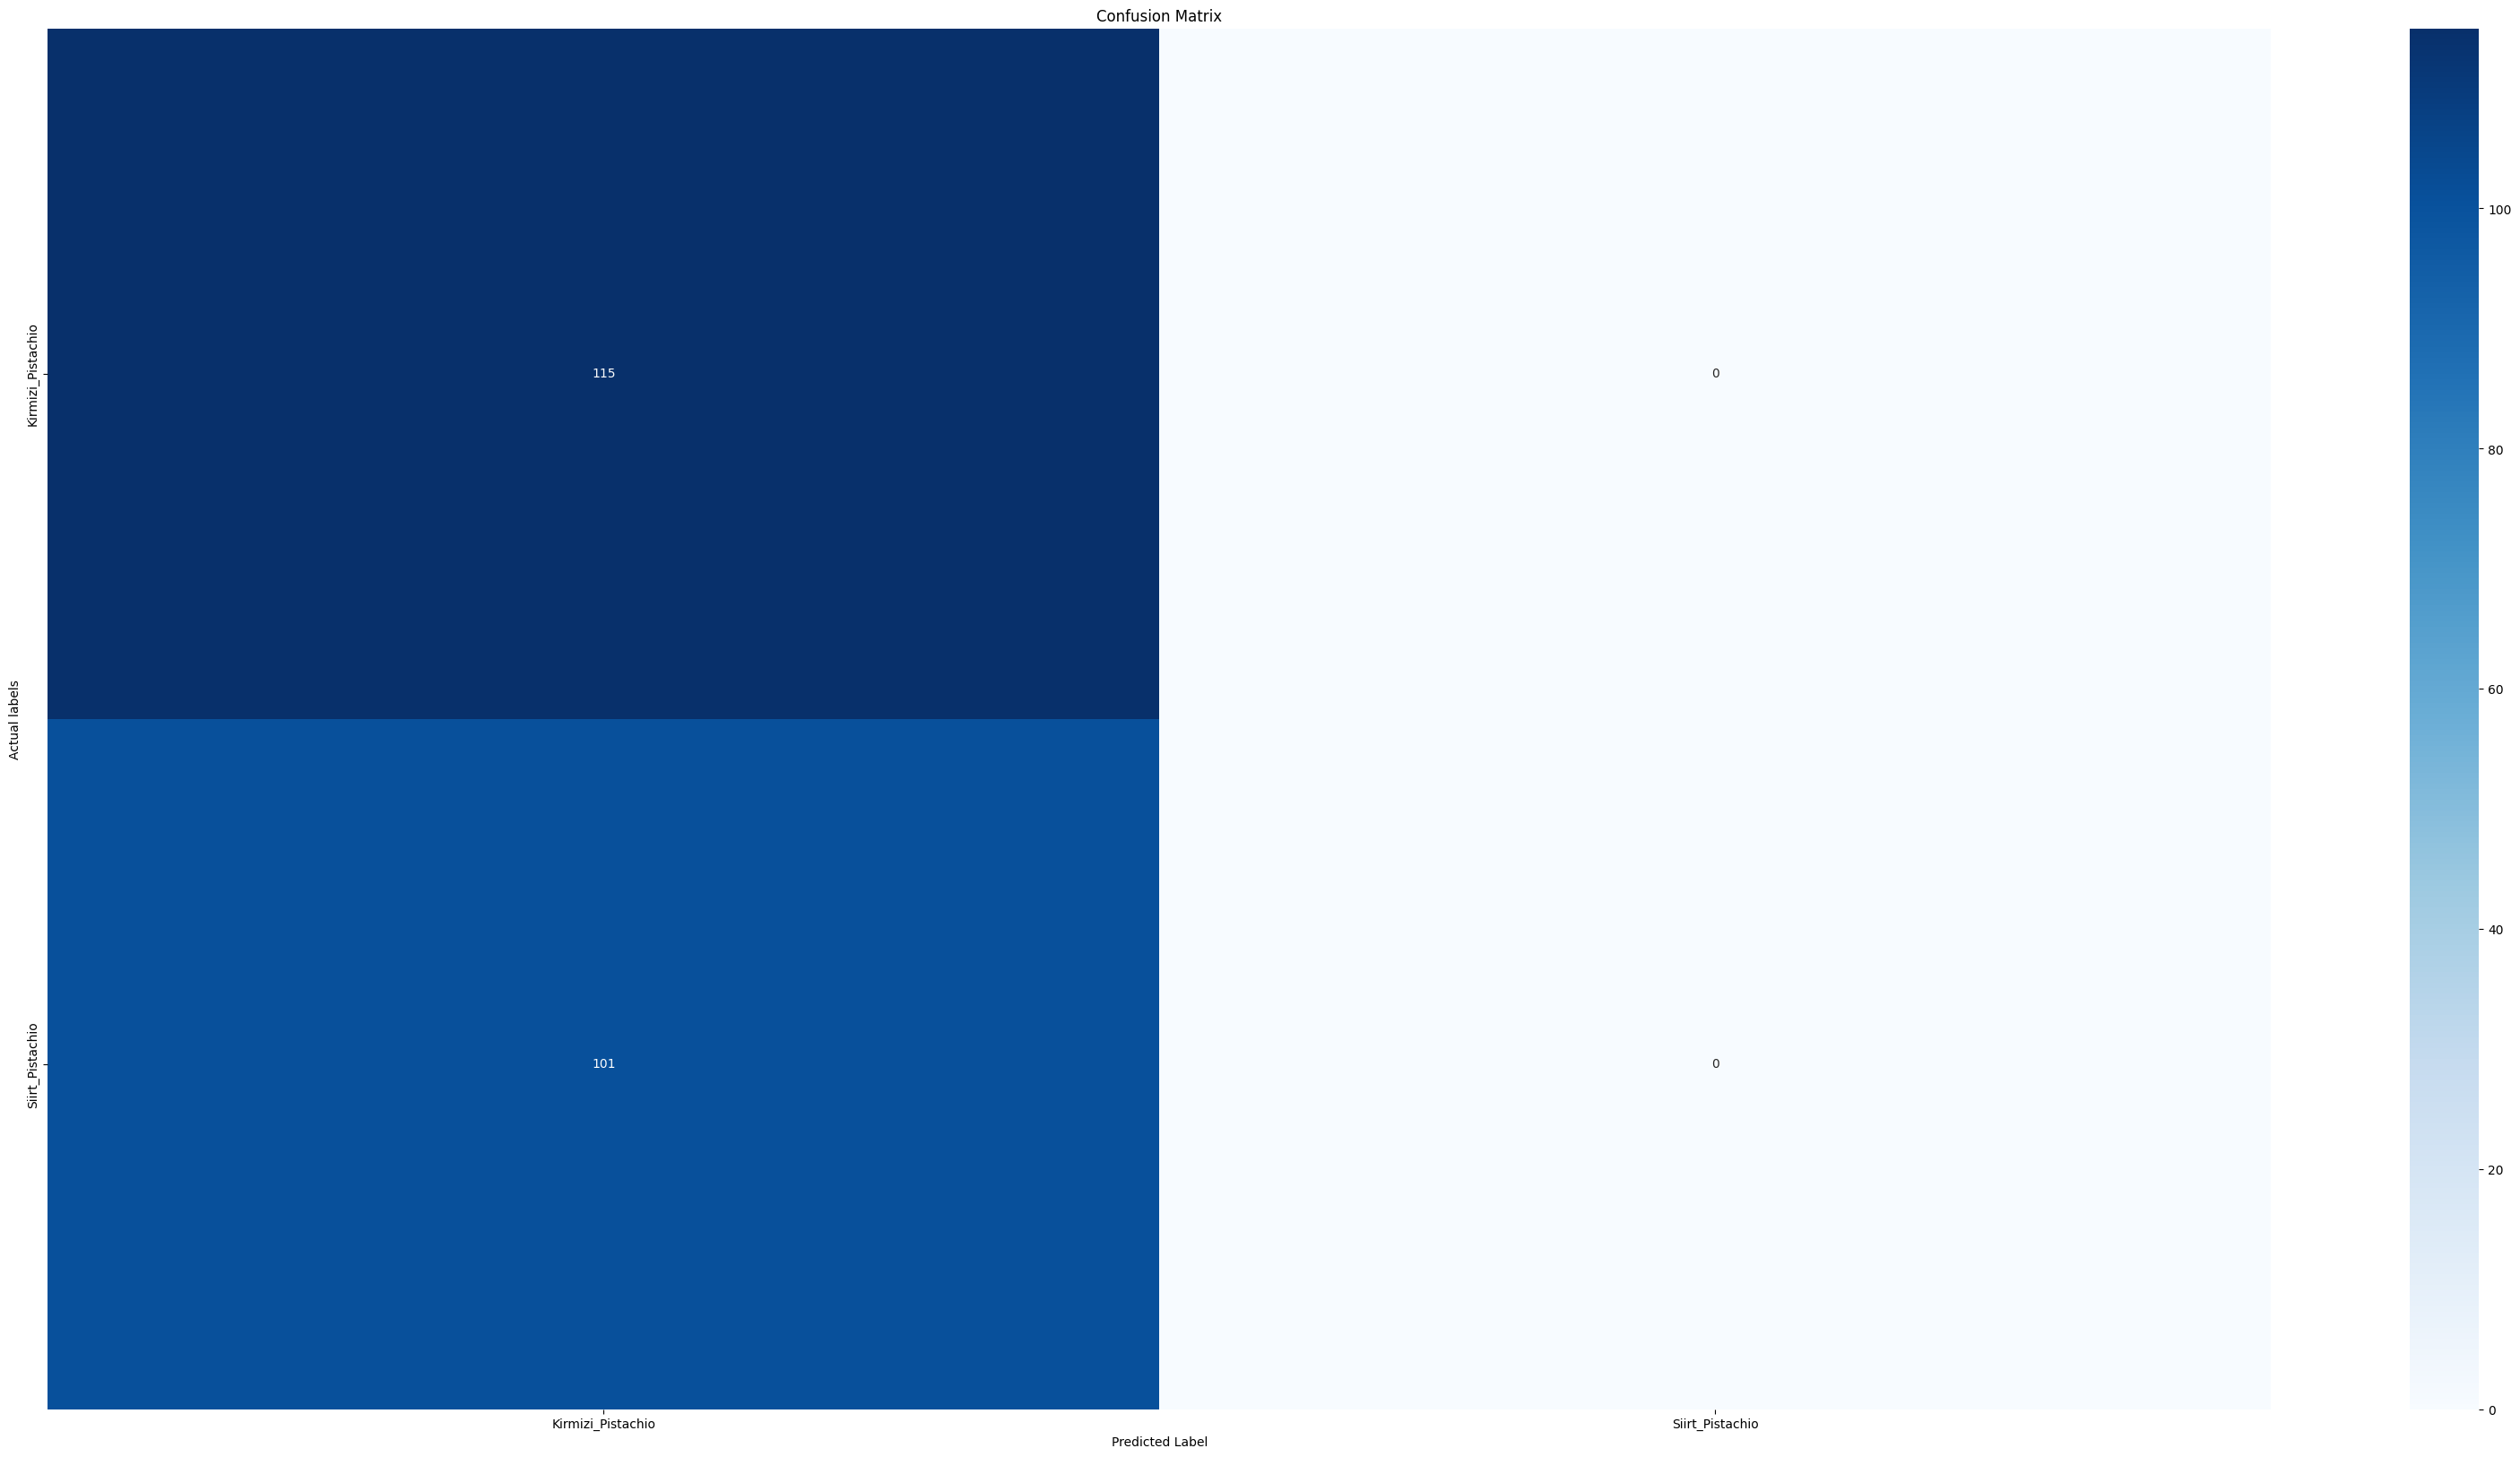

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average="weighted", zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average="weighted", zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average="weighted", zero_division=0)

print(f"Model Accuracy:{accuracy * 100:.2f}%")
print(f"Model Precision: {precision *100:.2f}%")
print(f"Model Recall:{recall * 100:.2f}%")
print(f"Model F1 Score:{f1 * 100:.2f}%")

print(classification_report(actual_labels, predicted_labels))

cm = confusion_matrix(actual_labels, predicted_labels)
class_names = test_loader.dataset.dataset.classes

plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual labels')
plt.show()

